# Hands-on Machine Learning

## Session 7: Deep Learning

by Leon Weninger

### Goal of this session

In this session you will:
* implement a deep neural network
* learn about different layer types and activation functions
* experiment with visualization techniques

Mind that there are still a few things we hide behind the scenes:
* Data Loading / Handling is done using framework utilities (see additional pytorch doc)
* Data Augmentation will be covered in a later session

### Dataset

This session uses the PascalVOC dataset, which is accessible on this server.
The dataset comprises input images that can be classified with different strategies.
We consider an image classification problem, i.e. decide which objects from a finite set of classes appear in the input image.
Since multiple objects may appear in each image, this is a multi-label classification task.

Let's dive right into the task:
Make sure to run the imports and continue loading the dataset to RAM.

In [1]:
import os
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

%matplotlib inline

First, we define if the network should run on GPU or CPU. On the official tutorial machines, a GPU is available. Remember later on to specify the network to run on "device".

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Loading the dataset

We prepared a loader for you that can automatically grab a training- and testset.

In [3]:
dset_path = os.path.join(os.path.abspath(os.environ["HOME"]), 'datasets')
try:
    voc_train = VOCSegmentation(root=dset_path, download=False, image_set="train")
    voc_val = VOCSegmentation(root=dset_path, download=False, image_set="val")
except RuntimeError:
    if not os.path.isdir(dset_path):
            os.makedirs(dset_path)
    VOCSegmentation(root=dset_path, download=True)
    voc_train = VOCSegmentation(root=dset_path, download=False, image_set="train")
    voc_val = VOCSegmentation(root=dset_path, download=False, image_set="val")

A simple lookup table from numerical values to names of the objects

In [4]:
class_to_label = {0: 'background', 1:'aeroplane', 2:'bicycle', 3:'bird', 4:'boat', 5:'bottle', 6:'bus', 7:'car', 8:'cat', 9:'chair', 10:'cow', 11:'diningtable',
12:'dog', 13:'horse', 14:'motorbike', 15:'person', 16:'potted plant', 17:'sheep', 18:'sofa', 19:'train', 20:'tv/monitor'}

Run the cell below a few times to get an overview of the data available.
The labels assigned to the classes are shown above the images

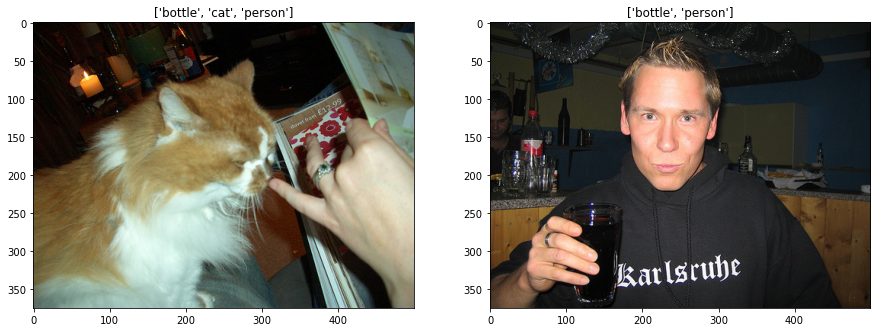

In [5]:
plt.subplots(2, 1, figsize=(15,15))
for i in range(2):
    img, mask = voc_train[np.random.randint(0,voc_train.__len__() + 1)]
    plt.subplot(1,2,i+1)
    plt.imshow(img)
    numerical_labels = np.unique(mask)
    #numerical_labels = np.array(mask)
    plt.title([class_to_label[i] for i in numerical_labels[1:-1]])
plt.show()

## Building a network

### Defining functional units

As introduced in the preparation, we are going to implement a VGGNet model as a classifier.
From the previous session you know the setup of classical Multilayer Perceptrons.

**Q1a:** Which other layer types appear in the VGG architecture?
Conv layer, Batch norm layer, ReLU layer, Maxpool layer.

The VGG architecture has a rather simple structure

**Q1b:** How can a VGG net be structured in small functional units (3-4 layers)?


#### ... write your answers/ideas in this box

The blocks of the VGGNet should look like this:
![Blockstructure](vgg16block-structure.png "Blockstructure")
Note that this structure is a little bit different from the original architecture. and reflects some recent advances in Deep Learning

**TASK** Implement the class below.

*Hint:* implement a functional block by defining a new python class which inherits from nn.Module (see pytorch doc).
You have to write an *init* and *forward* method. 

In [6]:
class VGGBlock(nn.Module):
    def __init__(self, ifeat, ofeat, N=2):
        super(VGGBlock, self).__init__()
        assert(N in (2, 3))
        self.N=N
        self.conv1=nn.Conv2d(ifeat,ofeat,3)
        self.conv2=nn.Conv2d(ofeat,ofeat,3)
        self.bnorm1 = nn.BatchNorm2d(ofeat)
        self.bnorm2 = nn.BatchNorm2d(ofeat)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((3,3), stride=2)
        
        if 3==N:
            self.conv3=nn.Conv2d(ofeat, ofeat, 1, padding =0)
            self.bnorm3 = nn.BatchNorm2d(ofeat)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bnorm1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bnorm2(x)
        x = self.relu(x)
        
        if self.N==3:
            x = self.conv3(x)
            x = self.bnorm3(x)
            x = self.relu(x)
        
        x = self.maxpool(x)
        
        return x


### Main Architecture

The standard VGG Net is used to predict a single class. Recall that in PascalVOC multiple objects may be present in an image.

**Q2:** What changes between a single and multi-label scenario?

In single label scenario, we will be taking the class which has the maximum value, but in multi-label class, we can fix a threshold. Whatever classes, crossing that threshold, those objects are present in the image.

#### ... write your answers/ideas in this box

Since the number of classes in PascalVOC is much smaller than in the ILSCVR Challenge (where VGG16 was benchmarked) the number of parameters for the Linear Layers can drastically be reduced in this session. Use _1024_ instead of _4096_ parameters.

**TASK** Using the block diagram in the preparation and your pytorch module above, implement a VGG-16 network as nn.Module.

In [7]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        # set up the blocks for the feature extractor part
        self.block1 = VGGBlock(3, 64)
        self.block2 = VGGBlock(64, 128)
        self.block3 = VGGBlock(128,256, N=3)
        self.block4 = VGGBlock(256,512, N=3)
        self.block5 = VGGBlock(512,512, N=3)

        
        self.dense1 = nn.Linear(512*5*5,1024)
        self.relu = nn.ReLU(True)
        self.dropout1 = nn.Dropout()
        self.dense2 = nn.Linear(1024, 1024)
        self.relu1 = nn.ReLU(True)
        self.dropout2 = nn.Dropout()
        self.output = nn.Linear(1024, 20)
        
        
        k = 0 # size of the feature plane after the extractor
        
        # don't forget the Dropout for a better learning behaviour

    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = torch.flatten(x, 1)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        x = self.relu1(x)
        x = self.dropout2(x)
        x = self.output(x)
        
        
        return x

### Data Preparation

This part covers necessary preparations to use the images from PascalVOC in the training process.
Read through the implementations below and using the pytorch doc explore what is done here.

In [8]:
class ToLabel(object):
    def __call__(self, pic):
        img = np.array(pic, np.uint8, copy=False)
        labels = np.unique(img)[1:-1]
        one_hot_targets = np.zeros(20)
        one_hot_targets[labels-1] = 1
        # we need to subtract one from labels, so that labels reaches from 0 to 19 (not from 1 to 20 as originally)
        return torch.from_numpy(one_hot_targets).float()

mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

inp_transform = transforms.Compose([
    transforms.Resize((320,320)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*mean_std)
])

tgt_transform = transforms.Compose([
    ToLabel(),
]
)

train_set = VOCSegmentation(root=dset_path, image_set='train', transform=inp_transform, target_transform=tgt_transform)
valid_set = VOCSegmentation(root=dset_path, image_set='val', transform=inp_transform, target_transform=tgt_transform)

train_loader = DataLoader(train_set, batch_size=8, num_workers=0, shuffle=True)
print(train_loader, type(train_loader))
val_loader = DataLoader(valid_set, batch_size=32, num_workers=0, shuffle=True)

<torch.utils.data.dataloader.DataLoader object at 0x7f52e4e94d90> <class 'torch.utils.data.dataloader.DataLoader'>


**TASK** Implement a training loop for the VGG16 model.
In PyTorch you need to set up model, loss function and optimizer. This is done as initialization before entering the loop.
During trainig we iterate multiple times through the dataset until the loss is not reduced any further.
Iteration in mini-batches is necessary since using the entire dataset at once would largely exceed the GPUs memory capacity.

For an improved estimation of the actual performance we iterate over the validation data as well (*Recap* session on unbiased evaluation).

In [23]:
network = VGG16()

# send the network to the GPU
# initialize your loss criterion
# initialize an optimizer object
network.to(device)
criterion = torch.nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam( network.parameters(), lr=learning_rate)

for epoch in range(3):
    
    train_loss = 0
    val_loss = 0
    accuracy = 0
    counter=0
    
    ep_train_losses = []
    for batch_nr, data in enumerate(train_loader):
        # get the required data and labels and wrap them in variables for the GPU processing
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # ...
        
        output = network.forward(inputs)
        # (optional) write some visualization to check if it works
        # ...
        
        # compute a loss from the network output
        loss = criterion(output, labels)
        
        ep_train_losses.append(loss)
        #loss is added for this batchsize=8, so , 
        #we finally divide the whole value by the total number of training inputs
        train_loss += loss.item()*inputs.size(0)
        # ...
        
        # ...  # zero old gradient values
        optimizer.zero_grad()
        # ...  # compute new gradients
        loss.backward()
        # ...  # update weights
        optimizer.step()
        
        
  
    with torch.no_grad():
        ep_valid_losses = []
        for batch_nr, data in enumerate(val_loader):
            # repeat the steps above for the validation set
            inputs = data[0]
            labels = data[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            output = network.forward(inputs)
            validation_loss = criterion(output, labels)
            val_loss += validation_loss.item()*inputs.size(0)
            
            ep_valid_losses.append(validation_loss)
            
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(val_loader.dataset)
    # Print out the information
    print('Epoch: {} training error %: {} validation error%: {}'.format(epoch, train_loss, valid_loss))

Epoch: 0 training error %: 0.07359273159683076 validation error%: 0.06702087130050481
Epoch: 1 training error %: 0.06703962025339485 validation error%: 0.06670206541477029
Epoch: 2 training error %: 0.06667100821362167 validation error%: 0.06638472512354104


### Visualize some examples

Verification is important! Let's first visualize some examples, so that we can see how good the network performed

To assess the quality of the model we have to find suitable measures to quantify the results for our test and validation data (ideally in a way we can easily understand), but more often than not, it will help tremendously to simply browse through some examples and verify the model by manual inspection.

In [11]:
# Visualizing outputs
visualize_loader = DataLoader(train_set, batch_size=1, num_workers=0, shuffle=True)
l_iter = iter(visualize_loader)

def lbls2names(nums):
    nums = lbls
    nums = nums.numpy().squeeze()
    labels_int = np.where(nums>0.5)
    labels_int = np.squeeze(np.asarray(labels_int), axis=0)

    names = "["
    for l in labels_int:
        names = names + class_to_label[l+1] + ", "
    names+="]"
    return names

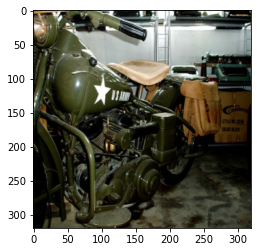

Labels = [motorbike, ]
Top5 = [dog, sheep, chair, cat, person, ]
Top1 = person


In [12]:
img, lbls = next(l_iter)  
img_rgb = ((np.moveaxis(img.numpy().squeeze(),0,2))*mean_std[1]+mean_std[0])
plt.imshow(np.clip(img_rgb,0,1))
plt.show()
lbls_str = lbls2names(lbls)
print("Labels = " + lbls_str)

with torch.no_grad():
    inputs = img.to(device)
    res = torch.sigmoid(network(inputs))
    # Remember the sigmoid function at the end of the network

#Show top5 and top1 predicted labels
prediction = np.squeeze(res.cpu().numpy())
top1 = np.argsort(prediction)[-1]
top5 = np.argsort(prediction)[-5:]
top5_string = "["
for i in top5:
    top5_string = top5_string + class_to_label[i+1] + ", "
top5_string+="]"
print("Top5 = " + top5_string)
print("Top1 = " + class_to_label[top1+1])

### Top-N Accuracy

We now want to quantify our accuracy.  
Implement a Top-5 error measure, i.e. we score whenever a label we expect from the ground-truth appears in our Top-5 predictions.  
Implement also a Top-1 error score.

In [15]:
top_5_scores = []
top_1_scores = []
for img_nr, data in enumerate(val_loader):
    imgs, lbls = data
    
    network.eval()
    with torch.no_grad():
        inputs = imgs.to(device)
        output = torch.sigmoid(network(inputs))
    prediction = np.squeeze(output.cpu().numpy())
    top5 = np.argsort(prediction, axis=1)[:,-5:]
    top1 = np.argsort(prediction, axis=1)[:,-1]
    
    labels = lbls.numpy()